# 🚨 Churn Prediction System using Machine Learning

Welcome to this hands-on churn prediction project. We aim to predict whether a customer is likely to churn (leave the service) based on their historical behavior and attributes. This system is especially useful for industries like telecom, banking, and SaaS.

In this notebook, we will:
- Load and preprocess a real-world dataset
- Build and compare multiple classification models
- Evaluate their performance
- Visualize key insights and export churn predictions for dashboarding


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


## Uploading Dataset

We will use the **Telco Customer Churn Dataset** from Kaggle. Upload the CSV file using the upload widget below.


In [2]:
from google.colab import files
uploaded = files.upload()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


## 🧹 Step 2: Data Loading & Preprocessing

We will now load the dataset, check for missing values, and encode categorical features. We also convert the target column `Churn` into binary labels.


In [3]:
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric and fill missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)

# Convert target to binary
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Label encode categorical columns
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


/tmp/ipython-input-3-2596216105.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


## ✂️ Step 3: Split Dataset

We split the data into training and testing sets for model evaluation.


In [4]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 🤖 Step 4: Model Building & Evaluation

We'll train and evaluate three models:
- Logistic Regression
- Random Forest
- XGBoost

Metrics: Accuracy, Precision, Recall, F1-Score, Confusion Matrix


In [5]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔹 Model: {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409

Confusion Matrix:
 [[934 102]
 [156 217]]

🔹 Model: Random Forest
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1036
           1       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409

Confusion Matrix:
 [[944  92]
 [203 170]]

🔹 Model: XGBoost
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1036
           1       0.61      0.50      0.55       373

    accuracy              

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:50:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## 📈 Step 5: ROC Curve for Best Model (XGBoost)

Visualize how well the XGBoost model distinguishes between churners and non-churners using the ROC Curve.


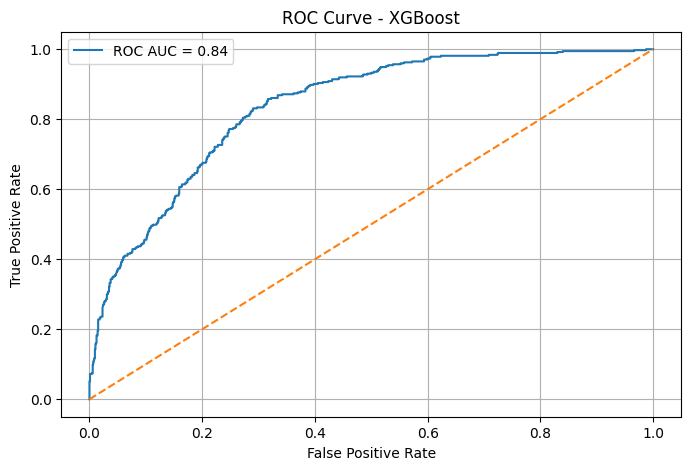

In [6]:
xgb_model = models["XGBoost"]
y_prob = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend()
plt.grid(True)
plt.show()


## 🧠 Step 6: Feature Importance

Identify which features influence customer churn the most using XGBoost’s feature importance.


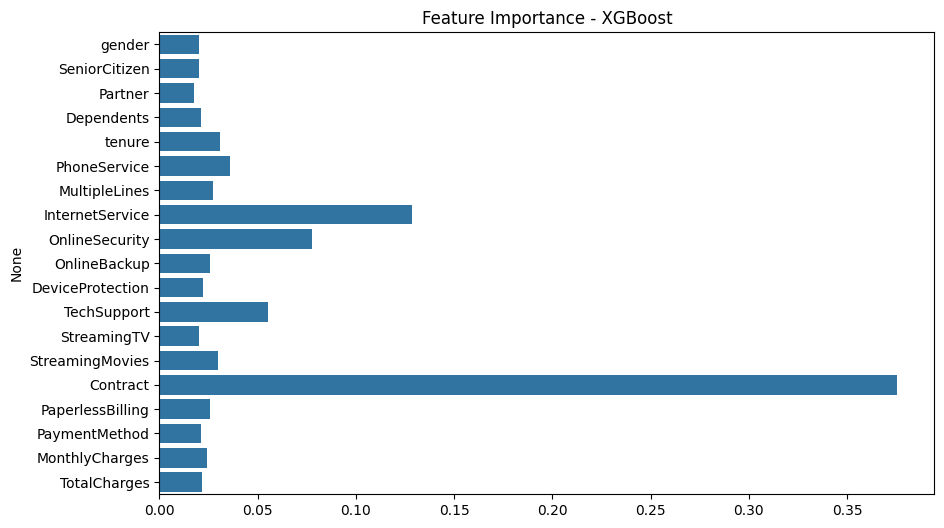

In [7]:
plt.figure(figsize=(10,6))
importances = xgb_model.feature_importances_
features = X.columns
sns.barplot(x=importances, y=features)
plt.title("Feature Importance - XGBoost")
plt.show()


## 📤 Step 7: Export Predictions for Power BI / Dashboard

We’ll now generate churn probability for each customer and export it as a CSV to build a Power BI dashboard.


In [9]:
df['Churn_Probability'] = xgb_model.predict_proba(X)[:,1]
df.to_csv("Churn_Predictions.csv", index=False)
print("Exported to Churn_Predictions.csv")
from google.colab import files
files.download("Churn_Predictions.csv")


Exported to Churn_Predictions.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 📌 Final Insights

 High churn risk among:
- Customers with month-to-month contracts
- Users with electronic check payment
- Low tenure customers
